In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
UC_Sampled = pd.read_csv('datasets/uncontrollable_sample.csv', index_col='id')
df_controllable_sampled = pd.read_csv('datasets/controllable_sampled.csv', index_col = 'id')
df_controllable_all = pd.read_csv('Faizan_scratch/Controllables/controllable_cleaned_features.csv', index_col='id')
df_uncontrollable_all = pd.read_csv('Faizan_scratch/uncontrollable_cleaned_features.csv', index_col='id')

df_all_features = df_controllable_all.merge(df_uncontrollable_all, left_index=True, right_index=True)
df_all_features = df_all_features.drop(columns=['host_is_superhost', 'Label_y'])
df_all_features = df_all_features.rename(columns={'Label_x':'Label'})

uncontrollable_columns = UC_Sampled.drop(columns='Label').columns
controllable_columns = df_controllable_sampled.drop(columns='Label').columns

# DATA SPLIT

In [3]:
from sklearn.model_selection import train_test_split, PredefinedSplit


X_trainval, X_test, Y_trainval, Y_test = train_test_split(df_all_features.drop('Label',1), 
                                                          df_all_features['Label'],
                                                         test_size = 0.2,
                                                         random_state = 42)


X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, 
                                                  Y_trainval, 
                                                  test_size = 0.25, # Corresponds to 20% of total data
                                                  random_state = 42)

# Use 'pds' as the cv parameter in GridSearchCV/RandomizedSearchCV:

split_index = [-1 if x in X_train.index else 0 for x in X_trainval.index]
pds = PredefinedSplit(test_fold = split_index)

In [4]:
# Split training/validation and test sets by feature categories

X_trainval_uc, X_trainval_c = X_trainval[uncontrollable_columns], X_trainval[controllable_columns]
X_test_uc, X_test_c = X_test[uncontrollable_columns], X_test[controllable_columns]

# For baseline models
X_train_uc, X_train_c = X_train[uncontrollable_columns], X_train[controllable_columns]
X_val_uc, X_val_c = X_val[uncontrollable_columns], X_val[controllable_columns]

In [10]:
from sklearn.preprocessing import StandardScaler

# Scale features for LR
# Note these will be used again for hyperparameter tuning, so need to scale:

scaler = StandardScaler()

X_train_uc = pd.DataFrame(scaler.fit_transform(X_train_uc), columns = uncontrollable_columns)
X_train_c = pd.DataFrame(scaler.fit_transform(X_train_c), columns = controllable_columns)

X_val_uc = pd.DataFrame(scaler.fit_transform(X_val_uc), columns = uncontrollable_columns)
X_val_c = pd.DataFrame(scaler.fit_transform(X_val_c), columns = controllable_columns)

X_trainval_uc = pd.DataFrame(scaler.fit_transform(X_trainval_uc), columns = uncontrollable_columns)
X_trainval_c = pd.DataFrame(scaler.fit_transform(X_trainval_c), columns = controllable_columns)

X_test_uc = pd.DataFrame(scaler.fit_transform(X_test_uc), columns = uncontrollable_columns)
X_test_c = pd.DataFrame(scaler.fit_transform(X_test_c), columns = controllable_columns)


# MODEL TUNING

In [5]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm, linear_model, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## Uncontrollable feature models

### Decision tree

In [29]:
#Baseline model
dt_uc_base = DecisionTreeClassifier(criterion = 'entropy')
fit = dt_uc_base.fit(X_train_uc, Y_train)
Y_pred = dt_uc_base.predict_proba(X_val_uc)[:,1]

fpr_dt_uc_base, tpr_dt_uc_base, thresholds_dt_uc_base = metrics.roc_curve(Y_val, Y_pred)
auc_dt_uc_base = metrics.auc(fpr_dt_uc_base, tpr_dt_uc_base)

print("Baseline LR AUC = {}".format(auc_dt_uc_base))

Baseline LR AUC = 0.5260262039201729


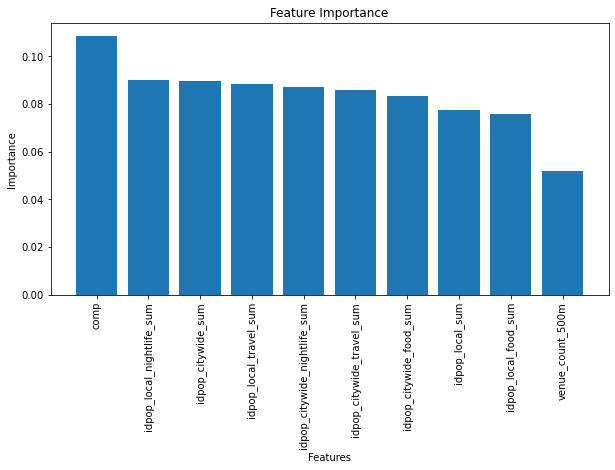

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

#Get feature importances
feature_mi = dt_uc_base.feature_importances_

#Sort indices
featureinds = feature_mi.argsort()

plt.figure(figsize=(10,5))
plt.title("Feature Importance")

#Plot features in order of importance
plt.bar(X_train_uc.columns.values[featureinds[::-1]][:10],feature_mi[featureinds[::-1]][:10])
plt.xticks(X_train_uc.columns.values[featureinds[::-1]][:10],rotation="90")
plt.xlabel('Features')
plt.ylabel('Importance')

plt.show()


In [33]:
X_train.columns.values[featureinds[::-1]][:10]

array(['guests_included', 'accommodates', 'host_listings_count',
       'bedrooms', 'bathrooms', 'beds', 'host_identity_verified',
       'host_response_rate', 'host_has_profile_pic', 'price'],
      dtype=object)

In [83]:
dt_parameters = {
    "min_samples_split": np.linspace(0.01, 0.2, 50),
    "min_samples_leaf": np.linspace(0.001, 0.1, 50),
    "criterion": ['gini', 'entropy']
    }

# Note the cv parameter 'pds'
dt_uc_base_GS = GridSearchCV(DecisionTreeClassifier(), dt_parameters, scoring = 'roc_auc', 
                     cv = pds, refit = 'roc_auc', n_jobs = -1)
dt_uc_base_GS.fit(X_trainval_uc, Y_trainval) # Note use of trainval data together

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1,  0])),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': array([0.001     , 0.00302041, 0.00504082, 0.00706122, 0.00908163,
       0.01110204, 0.01312245, 0.01514286, 0.01716327, 0.01918367,
       0.02120408, 0.02322449, 0.0252449 , 0.02726531, 0.02928571,
       0.03130612...
       0.08755102, 0.09142857, 0.09530612, 0.09918367, 0.10306122,
       0.10693878, 0.11081633, 0.11469388, 0.11857143, 0.12244898,
       0.12632653, 0.13020408, 0.13408163, 0.13795918, 0.14183673,
       0.14571429, 0.14959184, 0.15346939, 0.15734694, 0.16122449,
       0.16510204, 0.16897959, 0.17285714, 0.17673469, 0.18061224,
       0.1844898 , 0.18836735, 0.1922449 , 0.19612245, 0.2       ])},
             refit='roc_auc', scoring='roc_auc')

In [84]:
print(dt_uc_base_GS.best_estimator_)
print(dt_uc_base_GS.best_params_)
print("Best AUC is " + str(dt_uc_base_GS.best_score_))

DecisionTreeClassifier(criterion='entropy',
                       min_samples_leaf=0.0030204081632653063,
                       min_samples_split=0.03326530612244898)
{'criterion': 'entropy', 'min_samples_leaf': 0.0030204081632653063, 'min_samples_split': 0.03326530612244898}
Best AUC is 0.5814839446132004


### Logistic regression

In [30]:
# Baseline model
lr_uc_base = linear_model.LogisticRegression(max_iter = 2000, solver = 'liblinear')
lr_uc_base.fit(X_train_uc, Y_train)
Y_pred = lr_uc_base.predict_proba(X_val_uc)[:,1] # Using validation data to test baseline model

fpr_lr_uc_base, tpr_lr_uc_base, thresholds_lr_uc_base = metrics.roc_curve(Y_val, Y_pred)
auc_lr_uc_base = metrics.auc(fpr_lr_uc_base, tpr_lr_uc_base)

print("Baseline LR AUC = {}".format(auc_lr_uc_base))

Baseline LR AUC = 0.560076720080976


In [33]:
# Hyperparameter search

param_grid = [
    {'C': np.logspace(-5, 2, num = 5000), 
     'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [4000]}
]

scores = ['roc_auc', 'accuracy']

# Note the cv parameter 'pds'
lr_uc_base_RS = RandomizedSearchCV(linear_model.LogisticRegression(), param_grid, scoring = scores, 
                     cv = pds, refit = scores[0], n_jobs = -1)
lr_uc_base_RS.fit(X_trainval_uc, Y_trainval) # Note use of trainval data together for fitting

print("Best parameters: {}".format(lr_uc_base_RS.best_params_))
print("AUC of best performing model: {}".format(lr_uc_base_RS.best_score_))

Best parameters: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 4000, 'C': 0.2520004993764092}
AUC of best performing model: 0.5603464544217218


### Support vector machine

In [38]:
# Baseline model
svm_uc_base = svm.SVC()
svm_uc_base.fit(X_train_uc, Y_train)
Y_pred = svm_uc_base.decision_function(X_val_uc)

fpr_svm_uc_base, tpr_svm_uc_base, thresholds_svm_uc_base = metrics.roc_curve(Y_val, Y_pred)
auc_svm_uc_base = metrics.auc(fpr_svm_uc_base, tpr_svm_uc_base)

print("Baseline SVM AUC = {}".format(auc_svm_uc_base))

Baseline SVM AUC = 0.5609263074152422


In [40]:
# Hyperparameter search

param_grid = [
    {'C': np.logspace(-5, 2, num = 5000), 
     'kernel': ['linear', 'rbf', 'sigmoid', 'poly']}
]

scores = ['roc_auc', 'accuracy']

# Note the cv parameter 'pds'
svm_uc_base_RS = RandomizedSearchCV(svm.SVC(), param_grid, scoring = scores, 
                     cv = pds, refit = scores[0], n_jobs = -1)
svm_uc_base_RS.fit(X_trainval_uc, Y_trainval) # Note use of trainval data together for fitting

print("Best parameters: {}".format(svm_uc_base_RS.best_params_))
print("AUC of best performing model: {}".format(svm_uc_base_RS.best_score_))

Best parameters: {'kernel': 'rbf', 'C': 25.402764157911143}
AUC of best performing model: 0.573288899635568


### Gradient boosted decision tree

### Model with Uncontrollable features

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc.fit(X_train_uc, Y_train)
Y_pred = gbc.predict_proba(X_val_uc)[:,1]

fpr_lr_uc_base, tpr_lr_uc_base, thresholds_lr_uc_base = metrics.roc_curve(Y_val, Y_pred)
auc_lr_uc_base = metrics.auc(fpr_lr_uc_base, tpr_lr_uc_base)

print("Baseline LR AUC = {}".format(auc_lr_uc_base))
# fpr_lr_uc_base, tpr_lr_uc_base, thresholds_lr_uc_base = metrics.roc_curve(Y_val, Y_pred)
# auc_lr_uc_base = metrics.auc(fpr_lr_uc_base, tpr_lr_uc_base)

Baseline LR AUC = 0.5796232010969364


In [38]:
n_estimators = range(50,1500,50)
auc = []
for n in n_estimators:
    gbc = GradientBoostingClassifier(n_estimators=n)
    gbc.fit(X_train_uc, Y_train)
    Y_pred = gbc.predict_proba(X_val_uc)[:,1]

    fpr_lr_uc_base, tpr_lr_uc_base, thresholds_lr_uc_base = metrics.roc_curve(Y_val, Y_pred)
    auc_lr_uc_base = metrics.auc(fpr_lr_uc_base, tpr_lr_uc_base)
    auc.append(auc_lr_uc_base)
    #print("Baseline LR AUC = {}".format(auc_lr_uc_base))
# fpr_lr_uc_base, tpr_lr_uc_base, thresholds_lr_uc

Text(0.5, 1.0, "AUC's for different n_Estimators for a learning rate of 0.1")

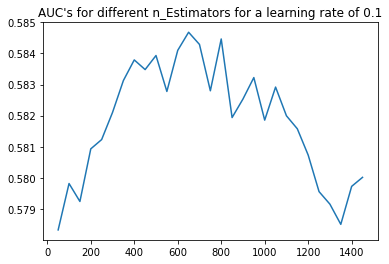

In [40]:
plt.plot(n_estimators,auc)
plt.title('AUC\'s for different n_Estimators for a learning rate of 0.1')

In [42]:
min_sample_split = np.linspace(0.01,0.5,12)
auc_mss = []
for m in min_sample_split:
    gbc = GradientBoostingClassifier(n_estimators=550, min_samples_split=m)
    gbc.fit(X_train_uc, Y_train)
    Y_pred = gbc.predict_proba(X_val_uc)[:,1]

    fpr_lr_uc_base, tpr_lr_uc_base, thresholds_lr_uc_base = metrics.roc_curve(Y_val, Y_pred)
    auc_lr_uc_base = metrics.auc(fpr_lr_uc_base, tpr_lr_uc_base)
    auc_mss.append(auc_lr_uc_base)

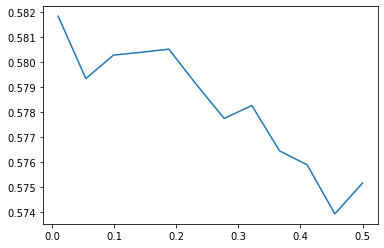

In [43]:
plt.plot(min_sample_split,auc_mss)

In [44]:
min_sample_leaf = np.linspace(0.001,0.5,12)
auc_msl = []
for m in min_sample_leaf:
    gbc = GradientBoostingClassifier(n_estimators=550, min_samples_leaf=0.05)
    gbc.fit(X_train_uc, Y_train)
    Y_pred = gbc.predict_proba(X_val_uc)[:,1]

    fpr_lr_uc_base, tpr_lr_uc_base, thresholds_lr_uc_base = metrics.roc_curve(Y_val, Y_pred)
    auc_lr_uc_base = metrics.auc(fpr_lr_uc_base, tpr_lr_uc_base)
    auc_msl.append(auc_lr_uc_base)

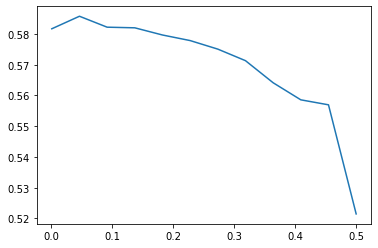

In [45]:
plt.plot(min_sample_leaf,auc_msl)

In [46]:
max_depth = [5,10,15,20,25]
auc_msd = []
for m in max_depth:
    gbc = GradientBoostingClassifier(n_estimators=550, min_samples_leaf=0.05,min_samples_split=0.01,max_depth=m)
    gbc.fit(X_train_uc, Y_train)
    Y_pred = gbc.predict_proba(X_val_uc)[:,1]

    fpr_lr_uc_base, tpr_lr_uc_base, thresholds_lr_uc_base = metrics.roc_curve(Y_val, Y_pred)
    auc_lr_uc_base = metrics.auc(fpr_lr_uc_base, tpr_lr_uc_base)
    auc_msd.append(auc_lr_uc_base)

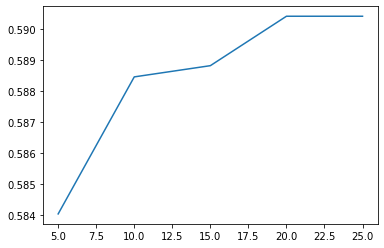

In [48]:
plt.plot(max_depth,auc_msd)

Text(0.5, 1.0, 'max_depth for learning rate=0.1')

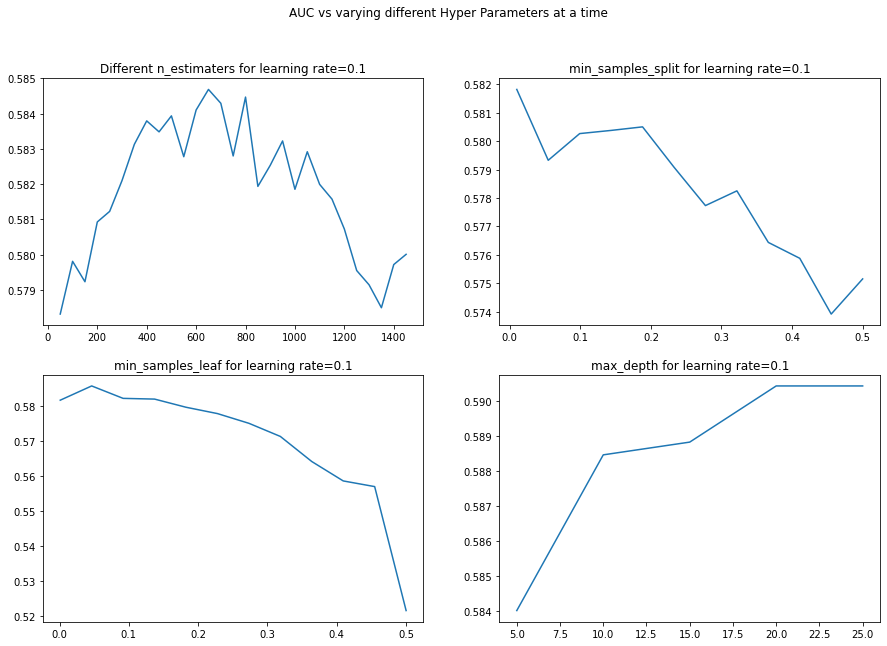

In [68]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
fig.suptitle('AUC vs varying different Hyper Parameters at a time')
ax[0][0].plot(n_estimators,auc)
ax[0][1].plot(min_sample_split,auc_mss)
ax[1][0].plot(min_sample_leaf,auc_msl)
ax[1][1].plot(max_depth,auc_msd)

ax[0][0].set_title('Different n_estimaters for learning rate=0.1')
ax[0][1].set_title('min_samples_split for learning rate=0.1')
ax[1][0].set_title('min_samples_leaf for learning rate=0.1')
ax[1][1].set_title('max_depth for learning rate=0.1')

In [58]:
# Hyperparameter search
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameters over which to search
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 50),
    "min_samples_leaf": np.linspace(0.1, 0.5, 50),
    "max_depth":[3,5,7,8,9,10],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators": [100,200,500,1000,1500,2000,2500]
    }

scores = ['roc_auc', 'accuracy']

gbc_uc_base_RS = RandomizedSearchCV(GradientBoostingClassifier(), parameters, random_state=0,scoring = scores, 
                     cv = pds, refit = scores[0], n_jobs = -1)

gbc_uc_base_RS.fit(X_trainval_uc, Y_trainval)
gbc_uc_base_RS.best_params_,gbc_uc_base_RS.best_estimator_
# Note the cv parameter 'pds'
# lr_uc_base_RS = RandomizedSearchCV(linear_model.LogisticRegression(), param_grid, scoring = scores, 
#                      cv = pds, refit = scores[0], n_jobs = -1)
# lr_uc_base_RS.fit(X_trainval_uc, Y_trainval) # Note use of trainval data together

KeyboardInterrupt: 

In [13]:
gbc = GradientBoostingClassifier(learning_rate=0.025, max_depth=10,
                            max_features='sqrt',
                            min_samples_leaf=0.1489795918367347,
                            min_samples_split=0.22244897959183674,
                            n_estimators=2500)
gbc.fit(X_train_uc, Y_train)
Y_pred = gbc.predict_proba(X_val_uc)[:,1]

fpr_lr_uc_base, tpr_lr_uc_base, thresholds_lr_uc_base = metrics.roc_curve(Y_val, Y_pred)
auc_lr_uc_base = metrics.auc(fpr_lr_uc_base, tpr_lr_uc_base)

print(f"Uncontrollable best params LR AUC = {auc_lr_uc_base}")
# fpr_lr_uc_base, tpr_lr_uc_base, thresholds_lr_uc_base = metrics.roc_curve(Y_val, Y_pred)
# auc_lr_uc_base = metrics.auc(fpr_lr_uc_base, tpr_lr_uc_base)

Uncontrollable best params LR AUC = 0.5767574001249829


In [69]:
# Hyperparameter search 2
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameters over which to search
parameters = {
    #"loss":["deviance"],
    "learning_rate": [0.025],
    "min_samples_split": np.linspace(0.005, 0.2, 50),
    "min_samples_leaf": np.linspace(0.001, 0.1, 50),
    "max_depth":[20,22,25,28,30],
    "max_features":["sqrt"],
    #"criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.8,0.9, 1.0],
    "n_estimators": [550,600,700,800,1000,1500,2000,2500]
    }

scores = ['roc_auc', 'accuracy']

gbc_uc_base_RS = RandomizedSearchCV(GradientBoostingClassifier(), parameters, random_state=0,scoring = scores, 
                     cv = pds, refit = scores[0], n_jobs = -1)

gbc_uc_base_RS.fit(X_trainval_uc, Y_trainval)
gbc_uc_base_RS.best_params_,gbc_uc_base_RS.best_estimator_,gbc_uc_base_RS.best_score_
# Note the cv parameter 'pds'
# lr_uc_base_RS = RandomizedSearchCV(linear_model.LogisticRegression(), param_grid, scoring = scores, 
#                      cv = pds, refit = scores[0], n_jobs = -1)
# lr_uc_base_RS.fit(X_trainval_uc, Y_trainval) # Note use of trainval data together

({'subsample': 1.0,
  'n_estimators': 1000,
  'min_samples_split': 0.12438775510204082,
  'min_samples_leaf': 0.05353061224489796,
  'max_features': 'sqrt',
  'max_depth': 22,
  'learning_rate': 0.025},
 GradientBoostingClassifier(learning_rate=0.025, max_depth=22,
                            max_features='sqrt',
                            min_samples_leaf=0.05353061224489796,
                            min_samples_split=0.12438775510204082,
                            n_estimators=1000),
 0.5826079114320846)

In [9]:
gbc_uc_base_RS.best_score_

0.5884722001727108

In [71]:
gbc= GradientBoostingClassifier(learning_rate=0.025, max_depth=22,
                            max_features='sqrt',
                            min_samples_leaf=0.05353061224489796,
                            min_samples_split=0.12438775510204082,
                            n_estimators=1000)


gbc.fit(X_train_uc, Y_train)
Y_pred = gbc.predict_proba(X_val_uc)[:,1]

fpr_lr_uc_base, tpr_lr_uc_base, thresholds_lr_uc_base = metrics.roc_curve(Y_val, Y_pred)
auc_lr_uc_base = metrics.auc(fpr_lr_uc_base, tpr_lr_uc_base)

print(f"Uncontrollable best params LR AUC = {auc_lr_uc_base}")

Uncontrollable best params LR AUC = 0.5825090362268135


In [50]:
gbc= GradientBoostingClassifier(learning_rate=0.05, max_depth=25,
                            max_features='sqrt', min_samples_leaf=0.034,
                            min_samples_split=0.08916666666666667,
                            n_estimators=2000)

gbc.fit(X_train_uc, Y_train)
Y_pred = gbc.predict_proba(X_val_uc)[:,1]

fpr_lr_uc_base, tpr_lr_uc_base, thresholds_lr_uc_base = metrics.roc_curve(Y_val, Y_pred)
auc_lr_uc_base = metrics.auc(fpr_lr_uc_base, tpr_lr_uc_base)

print(f"Uncontrollable best params LR AUC = {auc_lr_uc_base}")


Uncontrollable best params LR AUC = 0.5883194160188323


In [ ]:
# Hyperparameter search 2
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameters over which to search
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.025,0.03,0.04,0.05],
    "min_samples_split": np.linspace(0.01, 0.2, 25),
    "min_samples_leaf": np.linspace(0.001, 0.1, 25),
    "max_depth":[10,15,18,20,25,30],
    "max_features":["sqrt"],
    #"criterion": ["friedman_mse",  "mae"],
    #"subsample":[0.5, 0.8,0.9, 1.0],
    "n_estimators": [2500]
    }

scores = ['roc_auc', 'accuracy']

gbc_uc_base_RS = RandomizedSearchCV(GradientBoostingClassifier(), parameters, random_state=0,scoring = scores, 
                     cv = pds, refit = scores[0], n_jobs = -1)

gbc_uc_base_RS.fit(X_trainval_uc, Y_trainval)
gbc_uc_base_RS.best_params_,gbc_uc_base_RS.best_estimator_
# Note the cv parameter 'pds'
# lr_uc_base_RS = RandomizedSearchCV(linear_model.LogisticRegression(), param_grid, scoring = scores, 
#                      cv = pds, refit = scores[0], n_jobs = -1)
# lr_uc_base_RS.fit(X_trainval_uc, Y_trainval) # Note use of trainval data together

### Random forest

In [7]:
# Baseline model
rf_uc_base = RandomForestClassifier()
rf_uc_base.fit(X_train_uc, Y_train)
Y_pred = rf_uc_base.predict_proba(X_val_uc)[:,1]

fpr_rf_uc_base, tpr_rf_uc_base, thresholds_rf_uc_base = metrics.roc_curve(Y_val, Y_pred)
auc_rf_uc_base = metrics.auc(fpr_rf_uc_base, tpr_rf_uc_base)

print("Baseline RF AUC = {}".format(auc_rf_uc_base))

Baseline RF AUC = 0.5727109742187564


In [8]:
#n_estimators = range(1,200,10)
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
auc = []

for n in n_estimators:
    rf = RandomForestClassifier(n_estimators=n)
    rf.fit(X_train_uc, Y_train)
    Y_pred = rf.predict_proba(X_val_uc)[:,1]

    fpr_lr_uc_base, tpr_lr_uc_base, thresholds_lr_uc_base = metrics.roc_curve(Y_val, Y_pred)
    auc_lr_uc_base = metrics.auc(fpr_lr_uc_base, tpr_lr_uc_base)
    auc.append(auc_lr_uc_base)

Text(0, 0.5, 'AUC')

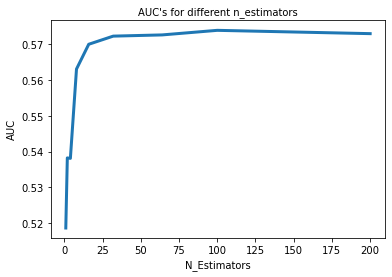

In [19]:
plt.plot(n_estimators,auc,linewidth=3)
plt.title('AUC\'s for different n_estimators',size=10)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('n_Estimators',size=10)
plt.ylabel('AUC',size=10)

In [51]:
max_features = [1, 2, 4, 8, 16, 32, 64, 100, 200]
aucs_mf = []

for m in max_features:
    rf = RandomForestClassifier(n_estimators=100,max_features=m)
    rf.fit(X_train_uc, Y_train)
    Y_pred = rf.predict_proba(X_val_uc)[:,1]

    fpr_rf_uc_base, tpr_rf_uc_base, thresholds_rf_uc_base = metrics.roc_curve(Y_val, Y_pred)
    auc_rf_uc_base = metrics.auc(fpr_rf_uc_base, tpr_rf_uc_base)
    aucs_mf.append(auc_rf_uc_base)

Text(0, 0.5, 'AUC')

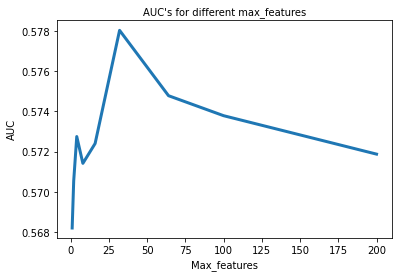

In [52]:
plt.plot(max_features,aucs_mf,linewidth=3)
plt.title('AUC\'s for different max_features',size=10)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Max_features',size=10)
plt.ylabel('AUC',size=10)

In [24]:
X_train_uc.shape

(23880, 228)

In [40]:
min_sample_split = [100, 200, 400, 800, 1600, 3200, 6400, 10000, 20000]
auc_sample_split = []
for m in min_sample_split:
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train_uc, Y_train)
    Y_pred = rf.predict_proba(X_val_uc)[:,1]

    fpr_rf_uc_base, tpr_rf_uc_base, thresholds_rf_uc_base = metrics.roc_curve(Y_val, Y_pred)
    auc_rf_uc_base = metrics.auc(fpr_rf_uc_base, tpr_rf_uc_base)
    auc_sample_split.append(auc_rf_uc_base)

Text(0, 0.5, 'AUC')

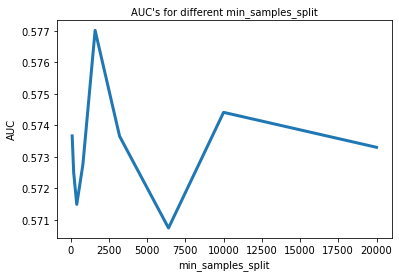

In [41]:
plt.plot(min_sample_split,auc_sample_split,linewidth=3)
plt.title('AUC\'s for different min_samples_split',size=10)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('min_samples_split',size=10)
plt.ylabel('AUC',size=10)

Text(0.5, 0, 'min_samples_split')

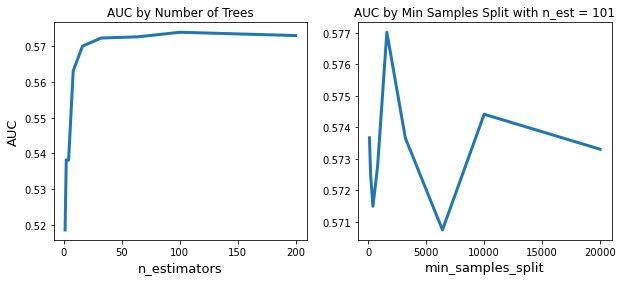

In [83]:

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
#fig.suptitle('AUC vs varying different Hyper Parameters at a time')

ax1.plot(n_estimators,auc,linewidth=3)
ax1.set(title='AUC by Number of Trees')
ax1.set_ylabel('AUC', fontsize = 13) # X label
ax1.set_xlabel('n_estimators', fontsize = 13) # X label
ax2.plot(min_sample_split,auc_sample_split,linewidth=3)
ax2.set(title='AUC by Min Samples Split with n_est = 101')
ax2.set_xlabel('min_samples_split', fontsize = 13) # X label

#ax[0][0].set_title('Different n_estimaters for learning rate=0.1')
#ax[0][1].set_title('min_samples_split for learning rate=0.1')

In [84]:
list(zip(min_sample_split,auc_sample_split))

[(100, 0.5736615539327116),
 (200, 0.5724886077056554),
 (400, 0.571487942596892),
 (800, 0.5727474401781308),
 (1600, 0.5770132306337316),
 (3200, 0.5736521056468771),
 (6400, 0.5707379572591148),
 (10000, 0.5744096748930163),
 (20000, 0.5732999595019294)]

In [25]:
# Hyperparameters over which to search
param_grid = [
    {'max_features': np.arange(1,200,10)
     ,'n_estimators': np.arange(1,200,10)
     ,'min_samples_leaf': np.arange(1,200,10)
     ,'min_samples_split': np.arange(100,2000,200)}
]

scores = ['roc_auc', 'accuracy']

# Note the cv parameter 'pds'
rf_uc_RS = RandomizedSearchCV(RandomForestClassifier(), param_grid, scoring = scores, 
                     cv = pds, refit = scores[0], n_jobs = -1)
rf_uc_RS.fit(X_trainval_uc, Y_trainval) # Note use of trainval data together

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1,  0])),
                   estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions=[{'max_features': array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
       131, 141, 151, 161, 171, 181, 191]),
                                         'min_samples_leaf': array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
       131, 141, 151, 161, 171, 181, 191]),
                                         'min_samples_split': array([ 100,  300,  500,  700,  900, 1100, 1300, 1500, 1700, 1900]),
                                         'n_estimators': array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
       131, 141, 151, 161, 171, 181, 191])}],
                   refit='roc_auc', scoring=['roc_auc', 'accuracy'])

In [26]:
rf_uc_RS.best_params_

{'n_estimators': 101,
 'min_samples_split': 300,
 'min_samples_leaf': 1,
 'max_features': 161}

In [35]:
# Tuned model
rf_uc_best = RandomForestClassifier(criterion='entropy',n_estimators=101
                                    ,min_samples_split=300, min_samples_leaf=1
                                    ,max_features=161)
rf_uc_best.fit(X_train_uc, Y_train)
Y_pred = rf_uc_best.predict_proba(X_val_uc)[:,1]

fpr_rf_uc_best, tpr_rf_uc_best, thresholds_rf_uc_best = metrics.roc_curve(Y_val, Y_pred)
auc_rf_uc_best = metrics.auc(fpr_rf_uc_best, tpr_rf_uc_best)

print("Best RF AUC = {}".format(auc_rf_uc_best))

Best RF AUC = 0.5927739825934135


In [53]:
# Tuned model
rf_uc_best = RandomForestClassifier(criterion='entropy',n_estimators=101
                                    ,min_samples_split=300, min_samples_leaf=1
                                    ,max_features=40)
rf_uc_best.fit(X_train_uc, Y_train)
Y_pred = rf_uc_best.predict_proba(X_val_uc)[:,1]

fpr_rf_uc_best, tpr_rf_uc_best, thresholds_rf_uc_best = metrics.roc_curve(Y_val, Y_pred)
auc_rf_uc_best = metrics.auc(fpr_rf_uc_best, tpr_rf_uc_best)

print("Best RF AUC = {}".format(auc_rf_uc_best))

Best RF AUC = 0.5966382367008582


## Controllable feature models

### Decision tree

In [85]:
#Baseline model
dt_c_base = DecisionTreeClassifier(criterion = 'entropy')
fit = dt_c_base.fit(X_train_c, Y_train)
Y_pred = dt_c_base.predict_proba(X_val_c)[:,1]

fpr_dt_c_base, tpr_dt_c_base, thresholds_dt_uc_base = metrics.roc_curve(Y_val, Y_pred)
auc_dt_c_base = metrics.auc(fpr_dt_c_base, tpr_dt_c_base)

print("Baseline LR AUC = {}".format(auc_dt_c_base))

Baseline LR AUC = 0.5650416204890913


In [86]:
dt_parameters = {
    "min_samples_split": np.linspace(0.01, 0.2, 50),
    "min_samples_leaf": np.linspace(0.001, 0.1, 50),
    "criterion": ['gini', 'entropy']
    }

# Note the cv parameter 'pds'
dt_c_base_GS = GridSearchCV(DecisionTreeClassifier(), dt_parameters, scoring = 'roc_auc', 
                     cv = pds, refit = 'roc_auc', n_jobs = -1)
dt_c_base_GS.fit(X_trainval_c, Y_trainval) # Note use of trainval data together

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1,  0])),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': array([0.001     , 0.00302041, 0.00504082, 0.00706122, 0.00908163,
       0.01110204, 0.01312245, 0.01514286, 0.01716327, 0.01918367,
       0.02120408, 0.02322449, 0.0252449 , 0.02726531, 0.02928571,
       0.03130612...
       0.08755102, 0.09142857, 0.09530612, 0.09918367, 0.10306122,
       0.10693878, 0.11081633, 0.11469388, 0.11857143, 0.12244898,
       0.12632653, 0.13020408, 0.13408163, 0.13795918, 0.14183673,
       0.14571429, 0.14959184, 0.15346939, 0.15734694, 0.16122449,
       0.16510204, 0.16897959, 0.17285714, 0.17673469, 0.18061224,
       0.1844898 , 0.18836735, 0.1922449 , 0.19612245, 0.2       ])},
             refit='roc_auc', scoring='roc_auc')

In [87]:
print(dt_c_base_GS.best_estimator_)
print(dt_c_base_GS.best_params_)
print("Best AUC is " + str(dt_c_base_GS.best_score_))

DecisionTreeClassifier(criterion='entropy',
                       min_samples_leaf=0.0030204081632653063,
                       min_samples_split=0.017755102040816328)
{'criterion': 'entropy', 'min_samples_leaf': 0.0030204081632653063, 'min_samples_split': 0.017755102040816328}
Best AUC is 0.6706278262698496


### Logistic regression

In [35]:
# Baseline model
lr_c_base = linear_model.LogisticRegression(max_iter = 2000, solver = 'liblinear')
lr_c_base.fit(X_train_c, Y_train)
Y_pred = lr_c_base.predict_proba(X_val_c)[:,1] # Using validation data to test baseline model

fpr_lr_c_base, tpr_lr_c_base, thresholds_lr_c_base = metrics.roc_curve(Y_val, Y_pred)
auc_lr_c_base = metrics.auc(fpr_lr_c_base, tpr_lr_c_base)

print("Baseline LR AUC = {}".format(auc_lr_c_base))

Baseline LR AUC = 0.686077321990503


In [36]:
# Hyperparameter search

param_grid = [
    {'C': np.logspace(-5, 5, num = 5000), 
     'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [4000]}
]

scores = ['roc_auc', 'accuracy']

# Note the cv parameter 'pds'
lr_c_base_RS = RandomizedSearchCV(linear_model.LogisticRegression(), param_grid, scoring = scores, 
                     cv = pds, refit = scores[0], n_jobs = -1)
lr_c_base_RS.fit(X_trainval_c, Y_trainval) # Note use of trainval data together for fitting

print("Best parameters: {}".format(lr_c_base_RS.best_params_))
print("AUC of best performing model: {}".format(lr_c_base_RS.best_score_))

Best parameters: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 4000, 'C': 50.89870193519685}
AUC of best performing model: 0.6872489094339775


### Support vector machine

In [39]:
# Baseline model
svm_c_base = svm.SVC()
svm_c_base.fit(X_train_c, Y_train)
Y_pred = svm_c_base.decision_function(X_val_c)

fpr_svm_c_base, tpr_svm_c_base, thresholds_svm_c_base = metrics.roc_curve(Y_val, Y_pred)
auc_svm_c_base = metrics.auc(fpr_svm_c_base, tpr_svm_c_base)

print("Baseline SVM AUC = {}".format(auc_svm_c_base))

Baseline SVM AUC = 0.7005392032446993


In [41]:
# Hyperparameter search

param_grid = [
    {'C': np.logspace(-5, 2, num = 5000), 
     'kernel': ['linear', 'rbf', 'sigmoid', 'poly']}
]

scores = ['roc_auc', 'accuracy']

# Note the cv parameter 'pds'
svm_c_base_RS = RandomizedSearchCV(svm.SVC(), param_grid, scoring = scores, 
                     cv = pds, refit = scores[0], n_jobs = -1)
svm_c_base_RS.fit(X_trainval_c, Y_trainval) # Note use of trainval data together for fitting

print("Best parameters: {}".format(svm_c_base_RS.best_params_))
print("AUC of best performing model: {}".format(svm_c_base_RS.best_score_))

Best parameters: {'kernel': 'linear', 'C': 1.9510035139852595}
AUC of best performing model: 0.6863120439543104


### Gradient boosted decision tree

In [16]:
#Baseline model
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc.fit(X_train_c, Y_train)
Y_pred = gbc.predict_proba(X_val_c)[:,1]

fpr_lr_uc_base, tpr_lr_uc_base, thresholds_lr_uc_base = metrics.roc_curve(Y_val, Y_pred)
auc_lr_uc_base = metrics.auc(fpr_lr_uc_base, tpr_lr_uc_base)

print("Baseline LR AUC = {}".format(auc_lr_uc_base))

Baseline LR AUC = 0.7119472341991797


In [17]:
# Hyperparameter search
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameters over which to search
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 50),
    "min_samples_leaf": np.linspace(0.1, 0.5, 50),
    "max_depth":[3,5,7,8,9,10],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators": [100,200,500,1000,1500,2000,2500]
    }

scores = ['roc_auc', 'accuracy']

gbc_uc_base_RS = RandomizedSearchCV(GradientBoostingClassifier(), parameters, random_state=0,scoring = scores, 
                     cv = pds, refit = scores[0], n_jobs = -1)

gbc_uc_base_RS.fit(X_trainval_c, Y_trainval)
gbc_uc_base_RS.best_params_,gbc_uc_base_RS.best_estimator_
# Note the cv parameter 'pds'
# lr_uc_base_RS = RandomizedSearchCV(linear_model.LogisticRegression(), param_grid, scoring = scores, 
#                      cv = pds, refit = scores[0], n_jobs = -1)
# lr_uc_base_RS.fit(X_trainval_uc, Y_trainval) # Note use of trainval data together

({'subsample': 1.0,
  'n_estimators': 2500,
  'min_samples_split': 0.22244897959183674,
  'min_samples_leaf': 0.1489795918367347,
  'max_features': 'sqrt',
  'max_depth': 10,
  'loss': 'deviance',
  'learning_rate': 0.025,
  'criterion': 'friedman_mse'},
 GradientBoostingClassifier(learning_rate=0.025, max_depth=10,
                            max_features='sqrt',
                            min_samples_leaf=0.1489795918367347,
                            min_samples_split=0.22244897959183674,
                            n_estimators=2500))

In [10]:
gbc =  GradientBoostingClassifier(learning_rate=0.025, max_depth=10,
                            max_features='sqrt',
                            min_samples_leaf=0.1489795918367347,
                            min_samples_split=0.22244897959183674,
                            n_estimators=2500)
gbc.fit(X_train_c, Y_train)
Y_pred = gbc.predict_proba(X_val_c)[:,1]

fpr_lr_uc_base, tpr_lr_uc_base, thresholds_lr_uc_base = metrics.roc_curve(Y_val, Y_pred)
auc_lr_uc_base = metrics.auc(fpr_lr_uc_base, tpr_lr_uc_base)

print(f"Controllable best params LR AUC = {auc_lr_uc_base}")

Controllable best params LR AUC = 0.7065143434458853


In [10]:
# Hyperparameter search 2
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameters over which to search
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.025],
    "min_samples_split": np.linspace(0.01, 0.2, 25),
    "min_samples_leaf": np.linspace(0.001, 0.1, 25),
    "max_depth":[10,15,18,20,25,30],
    "max_features":["sqrt"],
    #"criterion": ["friedman_mse",  "mae"],
    #"subsample":[0.5, 0.8,0.9, 1.0],
    "n_estimators": [2500]
    }

scores = ['roc_auc', 'accuracy']

gbc_uc_base_RS = RandomizedSearchCV(GradientBoostingClassifier(), parameters, random_state=0,scoring = scores, 
                     cv = pds, refit = scores[0], n_jobs = -1)

gbc_uc_base_RS.fit(X_trainval_c, Y_trainval)
gbc_uc_base_RS.best_params_,gbc_uc_base_RS.best_estimator_
# Note the cv parameter 'pds'

({'n_estimators': 2500,
  'min_samples_split': 0.12083333333333333,
  'min_samples_leaf': 0.021625000000000002,
  'max_features': 'sqrt',
  'max_depth': 30,
  'loss': 'deviance',
  'learning_rate': 0.025},
 GradientBoostingClassifier(learning_rate=0.025, max_depth=30,
                            max_features='sqrt',
                            min_samples_leaf=0.021625000000000002,
                            min_samples_split=0.12083333333333333,
                            n_estimators=2500))

In [11]:
gbc = GradientBoostingClassifier(learning_rate=0.025, max_depth=30,
                            max_features='sqrt',
                            min_samples_leaf=0.021625000000000002,
                            min_samples_split=0.12083333333333333,
                            n_estimators=2500)

gbc.fit(X_train_c, Y_train)
Y_pred = gbc.predict_proba(X_val_c)[:,1]

fpr_lr_uc_base, tpr_lr_uc_base, thresholds_lr_uc_base = metrics.roc_curve(Y_val, Y_pred)
auc_lr_uc_base = metrics.auc(fpr_lr_uc_base, tpr_lr_uc_base)

print(f"Controllable best params LR AUC = {auc_lr_uc_base}")

Controllable best params LR AUC = 0.7191144067967998


In [70]:
parameters = {
   "loss":["deviance"],
    "learning_rate": [0.025,0.03,0.04,0.05],
    "min_samples_split": np.linspace(0.01, 0.2, 25),
    "min_samples_leaf": np.linspace(0.001, 0.1, 25),
    "max_depth":[10,15,18,20,25,30],
    "max_features":["sqrt"],
    #"criterion": ["friedman_mse",  "mae"],
    #"subsample":[0.5, 0.8,0.9, 1.0],
    "n_estimators": [2500]
    }
scores = ['roc_auc', 'accuracy']

gbc_uc_base_RS = RandomizedSearchCV(GradientBoostingClassifier(), parameters, random_state=0,scoring = scores, 
                     cv = pds, refit = scores[0], n_jobs = -1)

gbc_uc_base_RS.fit(X_trainval_c, Y_trainval)
gbc_uc_base_RS.best_params_,gbc_uc_base_RS.best_estimator_


({'n_estimators': 2500,
  'min_samples_split': 0.12083333333333333,
  'min_samples_leaf': 0.021625000000000002,
  'max_features': 'sqrt',
  'max_depth': 30,
  'loss': 'deviance',
  'learning_rate': 0.025},
 GradientBoostingClassifier(learning_rate=0.025, max_depth=30,
                            max_features='sqrt',
                            min_samples_leaf=0.021625000000000002,
                            min_samples_split=0.12083333333333333,
                            n_estimators=2500))

# Random Forest

In [8]:
# Baseline model
rf_c_base = RandomForestClassifier(criterion='entropy',oob_score=True)
rf_c_base.fit(X_train_c, Y_train)
Y_pred = rf_c_base.predict_proba(X_val_c)[:,1]

fpr_rf_c_base, tpr_rf_c_base, thresholds_rf_c_base = metrics.roc_curve(Y_val, Y_pred)
auc_rf_c_base = metrics.auc(fpr_rf_c_base, tpr_rf_c_base)

print("Baseline RF AUC = {}".format(auc_rf_c_base))

Baseline RF AUC = 0.7163300696405025


In [51]:
gbc_uc_base_RS.best_score_# Hyperparameters over which to search
param_grid = [
    {'max_features': np.arange(1,65,5)
     ,'n_estimators': np.arange(1,200,10)
     ,'min_samples_leaf': np.arange(1,200,10)
     ,'min_samples_split': np.arange(100,2000,50)}
]

scores = ['roc_auc', 'accuracy']

# Note the cv parameter 'pds'
rf_c_RS = RandomizedSearchCV(RandomForestClassifier(), param_grid, scoring = scores, 
                     cv = pds, refit = scores[0], n_jobs = -1)
rf_c_RS.fit(X_trainval_c, Y_trainval) # Note use of trainval data together

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1,  0])),
                   estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions=[{'max_features': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61]),
                                         'min_samples_leaf': array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
       131, 141, 151, 161, 171, 181, 191]),
                                         'min_samples_split': array([ 100,  150,  200,  250,  300,  350,  400,  450,  500,  550,  600,
        650,  700,  750,  800,  850,  900,  950, 1000, 1050, 1100, 1150,
       1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700,
       1750, 1800, 1850, 1900, 1950]),
                                         'n_estimators': array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
       131, 141, 151, 161, 171, 181, 191])}],
                   refit='roc_auc', scoring=['roc_auc', 'accuracy

In [45]:
rf_c_RS.best_params_

{'n_estimators': 151,
 'min_samples_split': 350,
 'min_samples_leaf': 81,
 'max_features': 61}

In [11]:
### Random forest# Tuned model
rf_c_best = RandomForestClassifier(criterion='entropy',max_features=10,oob_score=True)
rf_c_best.fit(X_train_c, Y_train)
Y_pred = rf_c_best.predict_proba(X_val_c)[:,1]

fpr_rf_c_best, tpr_rf_c_best, thresholds_rf_c_best = metrics.roc_curve(Y_val, Y_pred)
auc_rf_c_best = metrics.auc(fpr_rf_c_best, tpr_rf_c_best)

print("Best RF AUC = {}".format(auc_rf_c_best))

Best RF AUC = 0.7140817884069343


# ULTIMATE BAKEOFF

## Uncontrollable

In [12]:


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm, linear_model


#Best models:

best_rf_uc = RandomForestClassifier(criterion='entropy', n_estimators=200, 
                                    max_features=11, oob_score=True,min_samples_leaf=61,min_samples_split=1402)
best_gb_uc = GradientBoostingClassifier(learning_rate=0.025, max_depth=15,
                            max_features='sqrt', min_samples_leaf=0.034,
                            min_samples_split=0.08916666666666667,
                            n_estimators=2500)
gbc.fit(X_train_c, Y_train)
best_dt_uc = DecisionTreeClassifier(criterion = 'gini', min_samples_leaf=180, min_samples_split=1050)
best_svm_uc = svm.SVC(kernel = 'rbf', C = 0.2681812609453013)
best_lr_uc = linear_model.LogisticRegression(C = 10**-1.5, penalty = 'l1', max_iter = 4000, solver = 'liblinear')


models = {'RF': best_rf_uc, 'GB' : best_gb_uc, 'DT' : best_dt_uc, 'SVM': best_svm_uc, 'LR': best_lr_uc}


In [13]:
from sklearn.model_selection import train_test_split

X = df_all_features[uncontrollable_columns]
Y = df_all_features['Label']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.80)

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns = uncontrollable_columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = uncontrollable_columns)

In [14]:
for model in models:
    models[model].fit(X_train, Y_train)

In [15]:
predictions_rf = best_rf_uc.predict_proba(X_test[uncontrollable_columns])[:,1]
predictions_gb = best_gb_uc.predict_proba(X_test[uncontrollable_columns])[:,1]
predictions_dt = best_dt_uc.predict_proba(X_test[uncontrollable_columns])[:,1]
predictions_svm = best_svm_uc.decision_function(X_test[uncontrollable_columns])
predictions_lr = best_lr_uc.predict_proba(X_test[uncontrollable_columns])[:,1]

predictions = {'RF': predictions_rf, 'GB' : predictions_gb, 'DT' : predictions_dt, 'SVM': predictions_svm, 'LR': predictions_lr}



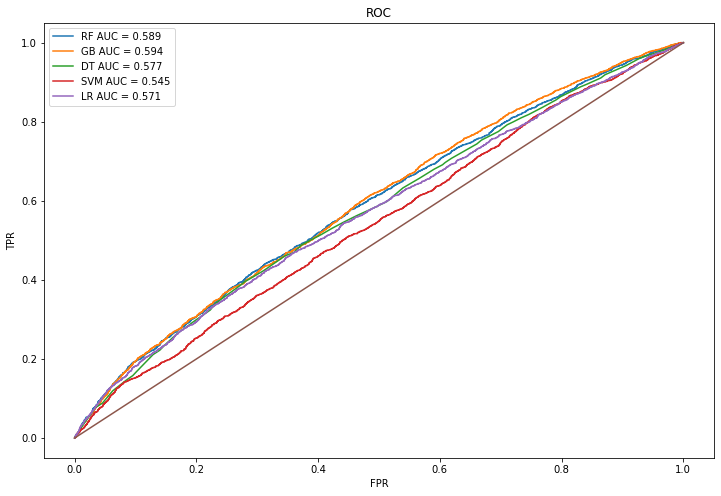

In [16]:
#Plot ROC curves of the two models

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, svm, metrics


plt.figure(figsize=(12,8))

for prediction in predictions:
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions[prediction])
    auc = metrics.auc(fpr,tpr)
    label = prediction + " AUC = %.3f"%auc
    plt.plot(fpr,tpr,label = label)
    

#Plot 45 degree line
plt.plot([0,1],[0,1])

plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

plt.show()

## Controllable

In [18]:
best_rf_c = RandomForestClassifier(criterion='entropy', max_features=8,
                       min_samples_split=100, n_estimators=160)
best_gb_c = GradientBoostingClassifier(learning_rate=0.025, max_depth=30,
                            max_features='sqrt',
                            min_samples_leaf=0.021625000000000002,
                            min_samples_split=0.12083333333333333,
                            n_estimators=2500)
best_dt_c = DecisionTreeClassifier(criterion = 'gini', min_samples_leaf=40, min_samples_split=350)
best_svm_c = svm.SVC(kernel = 'rbf',  C = 0.24175940791691308)
best_lr_c = linear_model.LogisticRegression(solver = 'liblinear', penalty = 'l1', max_iter = 2000, C = 0.20151357338155584)

models = {'RF': best_rf_c, 'GB' : best_gb_c, 'DT' : best_dt_c, 'SVM': best_svm_c, 'LR': best_lr_c}

In [19]:
X = df_all_features[controllable_columns]
Y = df_all_features['Label']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.80)

In [39]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns = controllable_columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = controllable_columns)

In [20]:
for model in models:
    models[model].fit(X_train, Y_train)

In [21]:
predictions_rf = best_rf_c.predict_proba(X_test[controllable_columns])[:,1]
predictions_gb = best_gb_c.predict_proba(X_test[controllable_columns])[:,1]
predictions_dt = best_dt_c.predict_proba(X_test[controllable_columns])[:,1]
predictions_svm = best_svm_c.decision_function(X_test[controllable_columns])
predictions_lr = best_lr_c.predict_proba(X_test[controllable_columns])[:,1]

predictions = {'RF': predictions_rf, 'GB' : predictions_gb, 'DT' : predictions_dt, 'SVM': predictions_svm, 'LR': predictions_lr}


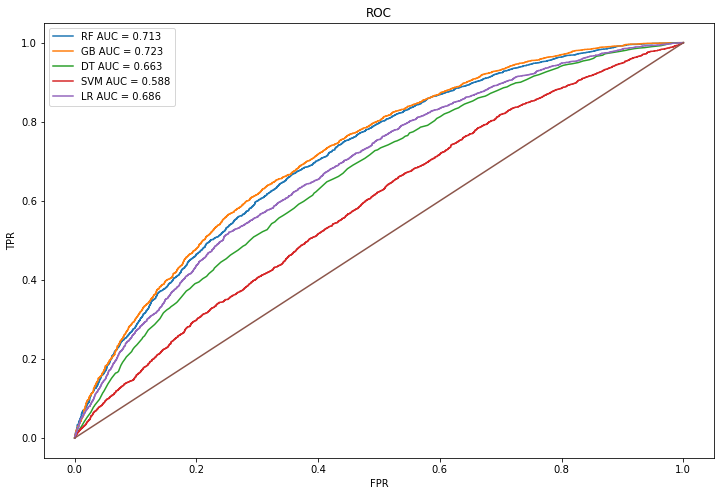

In [22]:
#Plot ROC curves of the two models

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, svm, metrics


plt.figure(figsize=(12,8))

for prediction in predictions:
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions[prediction])
    auc = metrics.auc(fpr,tpr)
    label = prediction + " AUC = %.3f"%auc
    plt.plot(fpr,tpr,label = label)
    

#Plot 45 degree line
plt.plot([0,1],[0,1])

plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

plt.show()

## Winners: 

### Controllable: 

RandomForestClassifier(criterion='entropy', max_features=8,
                       min_samples_split=100, n_estimators=160)


### Uncontrollable:

RandomForestClassifier(criterion='entropy', n_estimators=200, 
                                    max_features=11, oob_score=True,min_samples_leaf=61,min_samples_split=1402)

## Leveraging Uncontrollable and Controllable models

Basic Idea: Each location gets 2 scores - a location score and a property/quality score. We can bucket the listings into 4 buckets based on score combos

In [376]:
#Take the full dataset and split into train and test:

from sklearn.model_selection import train_test_split

X = df_all_features.drop(columns=['Label'])
Y = df_all_features['Label']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.80)

In [378]:
#Train the location model and the property model on the Train dataset using best model parameters


uncontrollable_columns = UC_Sampled.drop(columns='Label').columns
rf_uncontrollable = RandomForestClassifier(criterion='entropy', n_estimators=200, 
                                    max_features=11, oob_score=True,min_samples_leaf=61,min_samples_split=1402)
fit = rf_uncontrollable.fit(X_train[uncontrollable_columns], Y_train)

controllable_columns = df_controllable_sampled.drop(columns='Label').columns
rf_controllable = RandomForestClassifier(criterion='entropy', max_features=8,
                       min_samples_split=100, n_estimators=160)
fit = rf_controllable.fit(X_train[controllable_columns], Y_train)

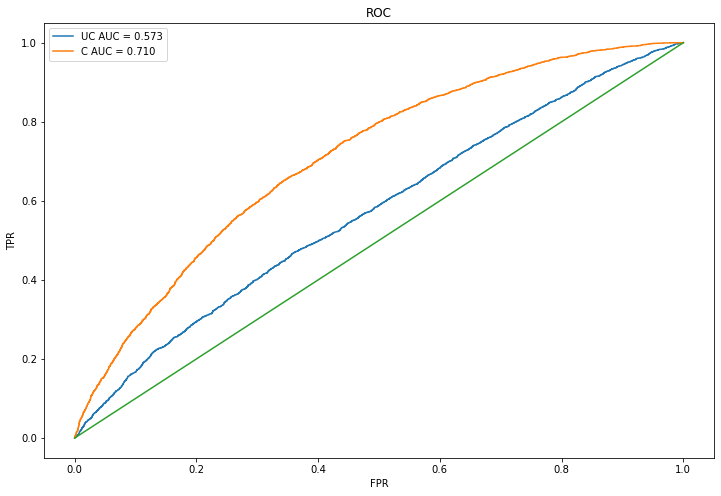

In [379]:
#Plot ROC curves of the two models

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, svm, metrics

predictions_rf_uc = rf_uncontrollable.predict_proba(X_test[uncontrollable_columns])[:,1]
predictions_rf_c = rf_controllable.predict_proba(X_test[controllable_columns])[:,1]


plt.figure(figsize=(12,8))

#Plot LR ROC/AUC
fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions_rf_uc)
auc = metrics.auc(fpr,tpr)
label = "UC AUC = %.3f"%auc
plt.plot(fpr,tpr,label = label)

#Plot LR ROC/AUC
fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions_rf_c)
auc = metrics.auc(fpr,tpr)
label = "C AUC = %.3f"%auc
plt.plot(fpr,tpr,label = label)


#Plot 45 degree line
plt.plot([0,1],[0,1])

plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

plt.show()

In [380]:
df_test_with_predictions = pd.DataFrame(Y_test)

In [381]:
df_test_with_predictions['Location_predictions_score'] = rf_uncontrollable.predict_proba(X_test[uncontrollable_columns])[:,1]
df_test_with_predictions['Property_predictions_score'] = rf_controllable.predict_proba(X_test[controllable_columns])[:,1]


In [382]:
df_test_with_predictions['Loc_bucket'] = pd.qcut(df_test_with_predictions['Location_predictions_score'], 3, labels=["low", "medium", "high"])

df_test_with_predictions['Prop_bucket'] = pd.qcut(df_test_with_predictions['Property_predictions_score'], 3, labels=["low", "medium", "high"])


In [383]:
statistics = df_test_with_predictions.groupby(['Loc_bucket', 'Prop_bucket']).agg(['mean', 'count'])['Label']

In [384]:
statistics['percent'] = statistics['count'] / len(df_test_with_predictions)

In [385]:
statistics

mean  count   percent
Loc_bucket Prop_bucket                           
low        low          0.232350   1119  0.140560
           medium       0.475787    826  0.103756
           high         0.644570    709  0.089059
medium     low          0.249431    878  0.110288
           medium       0.497256    911  0.114433
           high         0.659722    864  0.108529
high       low          0.336377    657  0.082527
           medium       0.534934    916  0.115061
           high         0.708603   1081  0.135787

<table style="height: 306px;" width="637">
<tbody>
<tr>
<td style="width: 152px;">&nbsp;</td>
<td style="width: 152px; text-align: center;"><strong>High Property Score</strong></td>
<td style="width: 152px; text-align: center;"><strong>Medium Property Score</strong></td>
<td style="width: 153px; text-align: center;"><strong>Low Property Score</strong></td>
</tr>
<tr>
<td style="width: 152px; text-align: center;"><strong>High Location Score</strong></td>
<td style="width: 152px;">
<p>Percent of Listings: 12.1%</p>
<p>% Actual Positives: 66.3%</p>
</td>
<td style="width: 152px;">
<p>Percent of Listings: 10.7%</p>
<p>% Actual Positives: 57.4%</p>
</td>
<td style="width: 153px;">
<p>Percent of Listings: 8.6%</p>
<p>% Actual Positives: 37.7%</p>
</td>
</tr>
<tr>
<td style="width: 152px; text-align: center;"><strong>Medium Location Score</strong></td>
<td style="width: 152px;">Percent of Listings: 10.9%
<p>% Actual Positives: 61.6%</p>
</td>
<td style="width: 152px;">Percent of Listings: 11.0%
<p>% Actual Positives: 50.2%</p>
</td>
<td style="width: 153px;">Percent of Listings: 11.1%
<p>% Actual Positives: 34.9%</p>
</td>
</tr>
<tr>
<td style="width: 152px; text-align: center;"><strong>Low Location Score</strong></td>
<td style="width: 152px;">
<p>Percent of Listings: 9.8%</p>
<p>% Actual Positives: 60.5%</p>
</td>
<td style="width: 152px;">
<p>Percent of Listings: 11.5%</p>
<p>% Actual Positives: 45.4%</p>
</td>
<td style="width: 153px;">
<p>Percent of Listings: 14.3%</p>
<p>% Actual Positives: 25.5%</p>
</td>
</tr>
</tbody>
</table>

In [23]:
X_train_c.head()

,host_response_rate,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,security_deposit,...,Amenties Include parking,Amenties Include Pets,Amenties Include Dishes and silverware,Amenties Include Coffee maker,Amenties Include Microwave,Amenties Include Refrigerator,offers_weekly_price,offers_monthly_price,charges_security_deposit,charges_cleaning_fee
id,,,,,,,,,,,,,,,,,,,,,
4571925.0,100.0,2.0,1.0,0.0,4.0,1.0,1.0,5.0,165.0,227.138887,...,0,0,0,0,0,0,1,1,0,1
1950311.0,100.0,2.0,1.0,1.0,3.0,1.0,2.0,2.0,151.0,100.000000,...,1,0,1,1,1,1,0,0,1,1
20812387.0,90.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,80.0,100.000000,...,1,0,1,1,1,1,0,0,1,1
20171578.0,100.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,140.0,0.000000,...,0,0,1,1,1,1,0,0,1,1
29126779.0,67.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,230.0,0.000000,...,0,0,1,1,1,1,0,0,1,1
